# EKF 

In [44]:
import numpy as np
import scipy
import argparse
import sys
import os
import time
import matplotlib.pyplot as plt

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    logRdt = theta[0] * rabbit - theta[1] * rabbit * fox
    logFdt = theta[2] * rabbit * fox - theta[3] * fox
    return np.stack([logRdt, logFdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = theta[0] - theta[0] * fox
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[0] * rabbit
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * fox
    # (1) / dF
    resultDx[:, 0, 1] = theta[2] * rabbit - theta[3]
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = rabbit
    # (0) / 1
    resultDtheta[:, 1, 0] = -rabbit * fox
    # (1) / 2
    resultDtheta[:, 2, 1] = rabbit * fox
    # (1) / 3
    resultDtheta[:, 3, 1] = -fox
    return resultDtheta

def fOdeScipy(t, z, a, b, c, d):
    rabbit = z[0]
    fox = z[1]
    theta = [a, b, c, d]
    Rdt = theta[0] * rabbit - theta[1] * rabbit * fox  # (1)
    Fdt = theta[2] * rabbit * fox - theta[3] * fox  # (2)
    return [Rdt, Fdt]

ekf_ls = np.zeros((100, 240, 6))
time_ls = np.zeros(100)
days = 20

for EachRep in range(100):
    start_time = time.time()
    yobs = np.load('LV observations.npy')[EachRep]
    ydata = yobs.copy()
    tvecObs = np.arange(0, days, 1/12)
    tvecFull = np.arange(0, days, 1/12)
    yFull = ydata.copy()
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])

    noise = 0.2
    dim_x = 2
    dim_theta = 4
    prior_mean_x0_theta = np.array([yFull[0, 0], yFull[0, 1], 0.6, 0.75, 1., 1.])
    prior_variance_x0_theta = np.diag([noise ** 2, noise ** 2, 1, 1, 1, 1])
    theta_roaming_variance_unit_time = np.diag([0.1, 0.01, 0.01, 0.1])

    estimate_x_theta = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta])
    variance_x_theta = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta, dim_x + dim_theta])

    estimate_x_theta[0] = prior_mean_x0_theta
    variance_x_theta[0] = prior_variance_x0_theta

    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]
        predicted_theta = estimate_x_theta[k - 1, dim_x:(dim_x + dim_theta)]
        previous_x = estimate_x_theta[k - 1, 0:dim_x]
        predicted_x = previous_x + delta_t * fOde(predicted_theta, previous_x.reshape([1, -1])).reshape([-1])
        jacobian_predict_x_x = delta_t * fOdeDx(predicted_theta, previous_x.reshape([1, -1])).reshape([dim_x, dim_x])
        jacobian_predict_x_x += np.eye(dim_x)
        jacobian_predict_x_theta = delta_t * fOdeDtheta(predicted_theta, previous_x.reshape([1, -1])).reshape([dim_theta, dim_x])
        jacobian_predict_theta_x = np.zeros([dim_x, dim_theta])
        jacobian_predict_theta_theta = np.eye(dim_theta)
        jacobian_predict = np.block([
            [jacobian_predict_x_x, jacobian_predict_theta_x],
            [jacobian_predict_x_theta, jacobian_predict_theta_theta]
        ])
        variance_predict = jacobian_predict.transpose() @ variance_x_theta[k-1] @ jacobian_predict
        variance_predict[dim_x:(dim_x + dim_theta), dim_x:(dim_x + dim_theta)] += theta_roaming_variance_unit_time * delta_t
        predicted_x_theta = np.concatenate([predicted_x, predicted_theta])
        if not np.any(np.isfinite(yFull[k, :])):
            variance_x_theta[k] = variance_predict
            estimate_x_theta[k] = predicted_x_theta
        else:
            yobs = yFull[k, :]
            jacobian_y_x =  np.eye(dim_x)
            jacobian_y_theta =  np.zeros([dim_theta, dim_x])
            jacobian_y = np.block([
                [jacobian_y_x],
                [jacobian_y_theta]
            ])
            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            jacobian_y = jacobian_y[:, idx_yobs]
            predicted_y = predicted_x[idx_yobs]
            variance_predicted_yobs = jacobian_y.transpose() @ variance_predict @ jacobian_y + noise**2 * np.eye(yobs.shape[0])
            covariance_xtheta_yobs = variance_predict @ jacobian_y
            invvar_predicted_yobs = np.linalg.inv(variance_predicted_yobs)
            predicted_x_theta = predicted_x_theta + covariance_xtheta_yobs @ invvar_predicted_yobs @ (yobs - predicted_y)
            condvar_x_theta = variance_predict - covariance_xtheta_yobs @ invvar_predicted_yobs @ covariance_xtheta_yobs.transpose()

            variance_x_theta[k] = condvar_x_theta
            estimate_x_theta[k] = predicted_x_theta

    ekf_ls[EachRep] = estimate_x_theta
    time_ls[EachRep] = time.time() - start_time
print(np.mean(time_ls), np.std(time_ls))

0.09597001314163207 0.004578162639315143


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


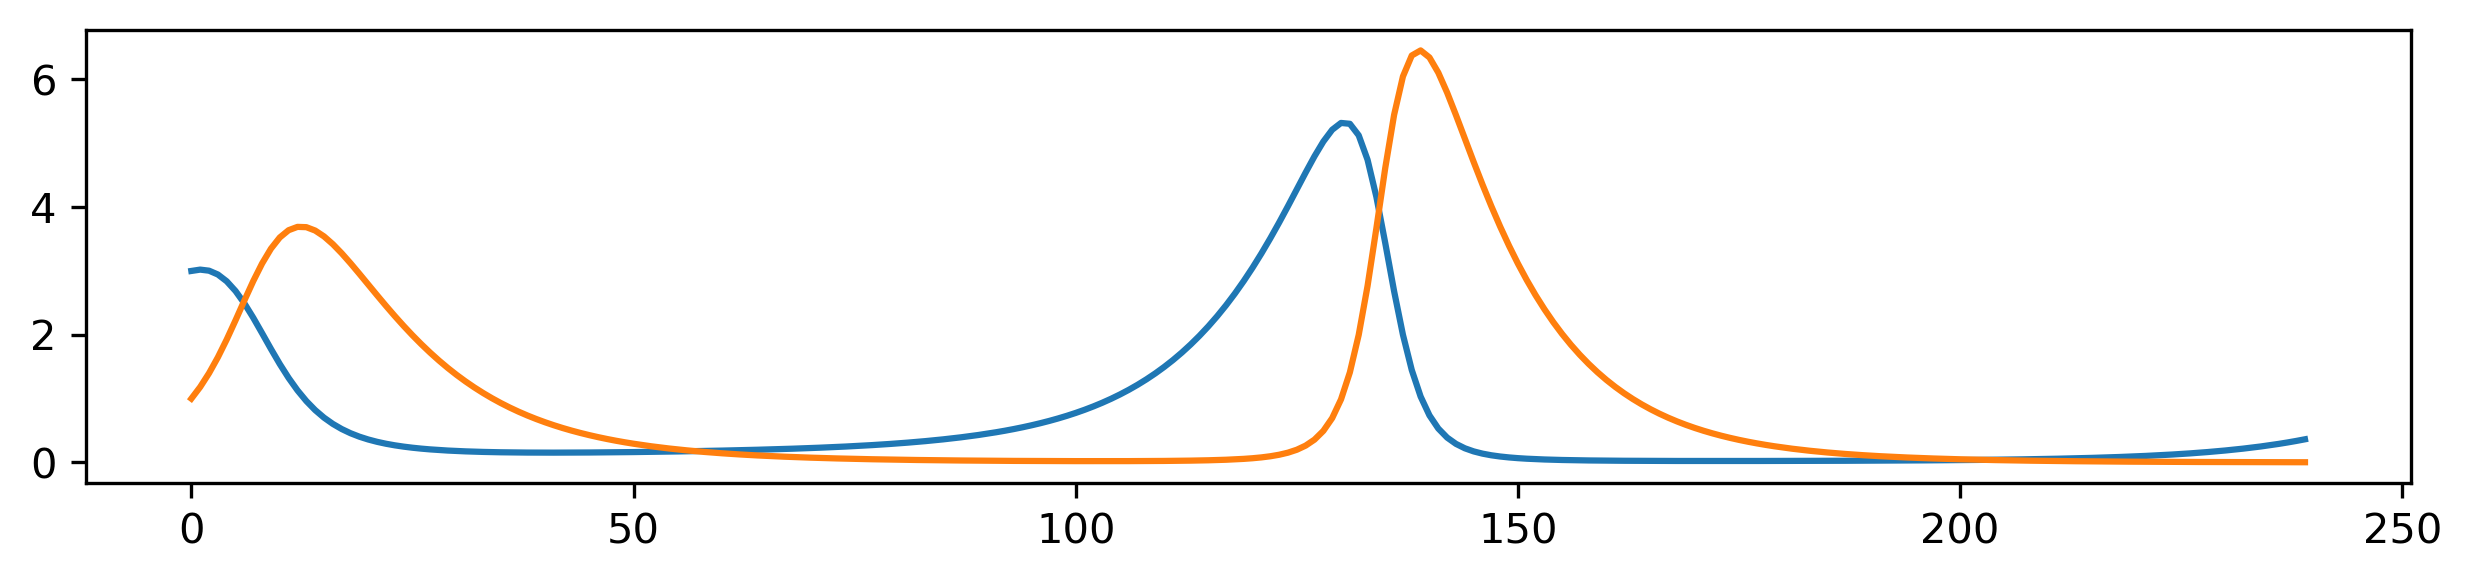

In [45]:
all_alpha = ekf_ls[:, :, 2]
all_beta = ekf_ls[:, :, 3]
all_delta = ekf_ls[:, :, 4]
all_gamma = ekf_ls[:, :, 5]

days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./obs_per_day)
true_alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
true_beta = 0.75 * np.ones(nobs)
true_delta = np.ones(nobs)
true_gamma = 1 + 0.1 * np.sin(6.28 * X / 10)

def recover_data(alpha, beta, delta, gamma, state0=[3., 1.], days=20, obs_per_day=12, linspace=1000):
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.zeros((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha[index] * state_ls[i - 1][0] - beta[index] * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta[index] * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]

    return states

true_x = recover_data(true_alpha, true_beta, true_delta, true_gamma)
plt.plot(true_x[:, 0])
plt.plot(true_x[:, 1])

all_reconstructed_x = np.zeros((100, 240, 2))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_alpha[i], all_beta[i], all_delta[i], all_gamma[i], state0=[3., 1.])

Text(0.5, 1.0, 'Predator')

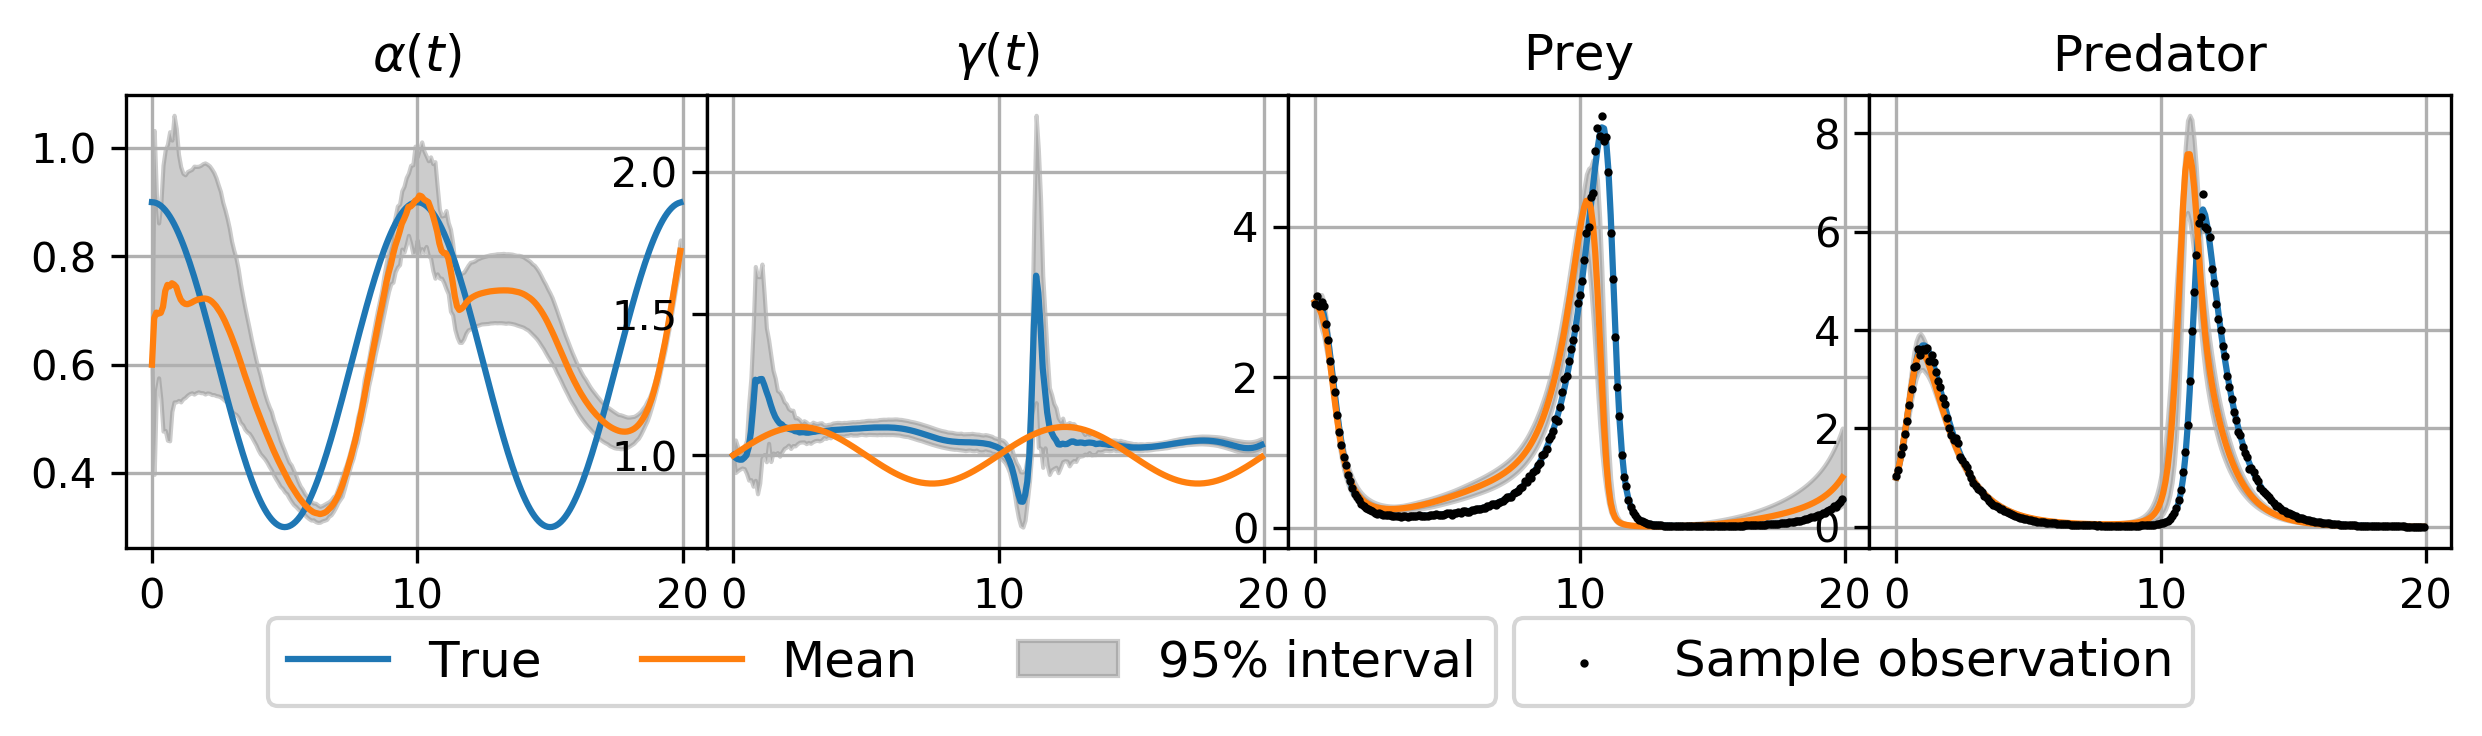

In [46]:

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # set figsize
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_alpha, 97.5, axis=0)
upper_95 = np.percentile(all_alpha, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_alpha, label='True')
plt.plot(x, np.mean(all_alpha, axis=0), label='Mean')
plt.title(r'$\alpha(t)$')
plt.grid()
plt.legend(bbox_to_anchor=(2.4, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_gamma, 97.5, axis=0)
upper_95 = np.percentile(all_gamma, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_gamma, axis=0))
plt.plot(x, true_gamma)
plt.grid()
plt.title(r'$\gamma(t)$')

yobs = np.load('G:/TVMAGI-LV/LV observations.npy')[1]
ax1 = plt.subplot(1, 4, 3) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 20, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 0])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Prey')
plt.legend(bbox_to_anchor=(1.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Predator')

# RMSE

In [47]:
RMSE_alpha = np.sqrt(np.mean(np.square(all_alpha - true_alpha), axis=0))
print(np.mean(RMSE_alpha), np.std(RMSE_alpha))
RMSE_beta = np.abs(all_beta - true_beta)
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_delta = np.abs(all_delta - true_delta)
print(np.mean(RMSE_delta), np.std(RMSE_delta))
RMSE_gamma = np.sqrt(np.mean(np.square(all_gamma - true_gamma), axis=0))
print(np.mean(RMSE_gamma), np.std(RMSE_gamma))

0.15750378450898977 0.09914174744039084
0.07960103591611388 0.03571508850088812
0.035482041806390106 0.042249156021562796
0.10151084837749312 0.08115676606193577


In [48]:
RMSE_R = np.zeros(100)
RMSE_F = np.zeros(100)
for i in range(100):
    RMSE_R[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 0] - true_x[:, 0])))
    RMSE_F[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 1] - true_x[:, 1])))
    
print(np.mean(RMSE_R), np.std(RMSE_R))
print(np.mean(RMSE_F), np.std(RMSE_F))

0.7497374305778761 0.07558563605555112
1.0896187259986265 0.06684470084109895
